In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [71]:
'''
Loading the graph with adjacency

graph contains 15 cities in cities.json and all CA DC charging stations from AFDC
'''

graph = src.graph.graph_from_json('Outputs/graph_full.json')
graph = src.routing.edge_types(graph)

In [72]:
'''
Removing non-corridor stations
'''
roadnums = []

for source, node in graph._node.items():
    
    roadnums.append(node['roadnum'])

unique_roadnum, unique_roadnum_count = np.unique(roadnums, return_counts = True)

roadnums_keep = unique_roadnum[(unique_roadnum_count >= 10) & (unique_roadnum != 'nan')]

nodes_keep = []

for source, node in graph._node.items():

    roadnum = node['roadnum']

    if node['type'] == 'city':

        nodes_keep.append(source)
    
    else:

        if roadnum in roadnums_keep:
    
            nodes_keep.append(source)

sng_combined = src.graph.subgraph(graph, nodes_keep)

In [73]:
'''
Creating Tesla and non-tesla SNGs
'''

tesla = []
other = []

for source, node in sng_combined._node.items():

    if node['type'] == 'city':

        tesla.append(source)
        other.append(source)

    else:

        if node['network'] == 'Tesla':

            tesla.append(source)

        else:

            other.append(source)

sng_tesla = src.graph.subgraph(graph, tesla)
sng_other = src.graph.subgraph(graph, other)

In [74]:
src.graph.graph_to_json(sng_combined, 'Outputs/sng_combined.json')
src.graph.graph_to_json(sng_tesla, 'Outputs/sng_tesla.json')
src.graph.graph_to_json(sng_other, 'Outputs/sng_other.json')

In [75]:
sng_other.number_of_nodes()

650

In [60]:
'''
Adding station objects
'''
deep_reload(src)

sng = sng_combined

cities = [k for k, v in sng._node.items() if v['type'] == 'city']

vehicle_kw = {
    # 'charge_target_soc': .8,
    'capacity': 49 * 3.6e6,
    'charge_rate': 170e3,
    'cases': 1,
    'risk_attitude': (.5, 1),
}

vehicle = src.routing.StochasticVehicle(**vehicle_kw)

station_kw = {
    'cases': 100,
    'reliability': .8,
    'base_delay': 60,
}

for source, node in sng._node.items():

    if node['type'] == 'station':

        seed = int(source[8:])

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **station_kw, seed = seed,
        )

        node['station'].expect(vehicle)

In [61]:
t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    sng, ['Fresno'],
    destinations = cities,
    objective = vehicle,
    method = 'bellman',
    return_paths = True,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 6.4180 seconds


In [62]:
print('Total Time:\n')
pprint({k: v['time'].mean() / 3600 for k, v in values.items() if 'station' not in k})
# print('\nDriving Time:\n')
# pprint({k: v['driving_time'].mean() / 3600 for k, v in values.items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in paths.items() if 'station' not in k})

Total Time:

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.351751234658656,
 'Crescent City': 9.127759941635375,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 7.048964750122601,
 'I-15 to Las Vegas (State Line)': 6.060009479785998,
 'I-80 to Reno (State Line)': 4.698810653965693,
 'Los Angeles': 3.318550537261838,
 'Redding': 5.364753886997446,
 'Sacramento': 2.6713354700854763,
 'San Diego': 5.531490666173296,
 'San Francisco': 2.9443037864912918,
 'San Jose': 2.513857364857367,
 'Stockton': 1.9591595904095913,
 'Yreka': 7.017394648106744}

Paths:

{'Bakersfield': ['Fresno', 'Bakersfield'],
 'Chico': ['Fresno', 'station_1063', 'Chico'],
 'Crescent City': ['Fresno', 'station_167', 'station_230', 'Crescent City'],
 'Fresno': ['Fresno'],
 'I-10 to Phoenix (State Line)': ['Fresno',
                                  'station_841',
                                  'station_1837',
                                  'I-10 to Phoenix (State Line)'],
 'I-15 to Las Vegas (State Line)': ['Fr

In [63]:
'''
Adding station objects
'''
deep_reload(src)

sng = sng_tesla

cities = [k for k, v in sng._node.items() if v['type'] == 'city']

vehicle_kw = {
    'charge_target_soc': .8,
    'capacity': 49 * 3.6e6,
    'cases': 1,
    'risk_attitude': (.5, 1),
}

vehicle = src.routing.StochasticVehicle(**vehicle_kw)

station_kw = {
    'cases': 100,
    'reliability': .8,
    'base_delay': 60,
}

for source, node in sng._node.items():

    if node['type'] == 'station':

        seed = int(source[8:])

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **station_kw, seed = seed,
        )

        node['station'].expect(vehicle)

In [64]:
t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    sng, ['Fresno'],
    destinations = cities,
    objective = vehicle,
    method = 'bellman',
    return_paths = True,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.4291 seconds


In [65]:
print('Total Time:\n')
pprint({k: v['time'].mean() / 3600 for k, v in values.items() if 'station' not in k})
# print('\nDriving Time:\n')
# pprint({k: v['driving_time'].mean() / 3600 for k, v in values.items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in paths.items() if 'station' not in k})

Total Time:

{'Bakersfield': 1.5477781213637707,
 'Chico': 4.4960528131408335,
 'Crescent City': 9.90812517102453,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 7.456865590131959,
 'I-15 to Las Vegas (State Line)': 6.496466960333944,
 'I-80 to Reno (State Line)': 4.823466593597853,
 'Los Angeles': 3.5730821383479285,
 'Redding': 5.594182025457251,
 'Sacramento': 2.596151526444774,
 'San Diego': 5.703594526467413,
 'San Francisco': 2.9443037864912918,
 'San Jose': 2.438673421216665,
 'Stockton': 1.8839756467688893,
 'Yreka': 7.393516462733357}

Paths:

{'Bakersfield': ['Fresno', 'station_1105', 'Bakersfield'],
 'Chico': ['Fresno', 'station_123', 'Chico'],
 'Crescent City': ['Fresno',
                   'station_167',
                   'station_1145',
                   'station_103',
                   'Crescent City'],
 'Fresno': ['Fresno'],
 'I-10 to Phoenix (State Line)': ['Fresno',
                                  'station_841',
                                  'station_1858',

In [57]:
'''
Adding station objects
'''
deep_reload(src)

sng = sng_other

cities = [k for k, v in sng._node.items() if v['type'] == 'city']

vehicle_kw = {
    # 'charge_target_soc': .8,
    'capacity': 49 * 3.6e6,
    'cases': 1,
    'risk_attitude': (.5, 1),
}

vehicle = src.routing.StochasticVehicle(**vehicle_kw)

station_kw = {
    'cases': 100,
    'reliability': .8,
    'base_delay': 60,
}

for source, node in sng._node.items():

    if node['type'] == 'station':

        seed = int(source[8:])

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **station_kw, seed = seed,
        )

        node['station'].expect(vehicle)

In [58]:
t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    sng, ['Fresno'],
    destinations = cities,
    objective = vehicle,
    method = 'bellman',
    return_paths = True,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 4.3424 seconds


In [59]:
print('Total Time:\n')
pprint({k: v['time'].mean() / 3600 for k, v in values.items() if 'station' not in k})
# print('\nDriving Time:\n')
# pprint({k: v['driving_time'].mean() / 3600 for k, v in values.items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in paths.items() if 'station' not in k})

Total Time:

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.992653029500699,
 'Crescent City': 11.133733429587904,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 8.407270464731205,
 'I-15 to Las Vegas (State Line)': 6.925163936223525,
 'I-80 to Reno (State Line)': 5.352193322540997,
 'Los Angeles': 3.8750633730274795,
 'Redding': 6.200023587500878,
 'Sacramento': 2.6713354700854763,
 'San Diego': 6.3618572633382815,
 'San Francisco': 2.9443037864912918,
 'San Jose': 2.513857364857367,
 'Stockton': 1.9591595904095913,
 'Yreka': 8.53432928178044}

Paths:

{'Bakersfield': ['Fresno', 'Bakersfield'],
 'Chico': ['Fresno', 'station_1787', 'Chico'],
 'Crescent City': ['Fresno', 'station_1683', 'station_1737', 'Crescent City'],
 'Fresno': ['Fresno'],
 'I-10 to Phoenix (State Line)': ['Fresno',
                                  'station_319',
                                  'station_202',
                                  'I-10 to Phoenix (State Line)'],
 'I-15 to Las Vegas (State Line)': [

In [144]:
deep_reload(src)

graph = src.routing.edge_types(graph)

In [145]:
cities = [k for k, v in graph._node.items() if v['type'] == 'city']

tesla_stations = [k for k, v in graph._node.items() if v.get('network', '') == 'Tesla']
np_stations = (
    [k for k, v in graph._node.items() if v.get('network', '') not in ['Tesla', 'RIVIAN_ADVENTURE']]
)

tesla_sng = src.graph.subgraph(graph, tesla_stations + cities)
np_sng = src.graph.subgraph(graph, np_stations + cities)

In [146]:
tesla_sng.number_of_nodes(), tesla_sng.number_of_edges()

(418, 87571)

In [147]:
np_sng.number_of_nodes(), np_sng.number_of_edges()

(1440, 1037520)

In [184]:
'''
Running with Dijkstra with default objective
'''
deep_reload(src)

objective = src.routing.Scout(field = 'time', edge_limit = 3800)

t0 = time.time()

costs, values, paths = src.routing.all_pairs_shortest_paths(
    np_sng, cities, objective = objective, return_paths = True
)

print(f'Executed in {time.time() - t0:.4f} seconds')

 [------------->] (15/15) 100.00%, 2.18 it/s, 7.34 s elapsed, 0.00 s remainingExecuted in 7.3452 seconds


In [180]:
utilized_stations = np.unique(
    np.concatenate(
        [n[1: -1] for paths_source in paths.values() for n in paths_source.values()]
    )
)

utilized_stations.shape

(217,)

In [186]:
np_sng_us = src.graph.subgraph(np_sng, list(utilized_stations) + cities)

In [190]:
'''
Running with Dijkstra with default objective
'''
deep_reload(src)

objective = src.routing.Scout(field = 'time', edge_limit = 7000)

t0 = time.time()

costs, values, paths = src.routing.all_pairs_shortest_paths(
    tesla_sng, cities, objective = objective, return_paths = True
)

print(f'\nExecuted in {time.time() - t0:.4f} seconds')

 [------------>] (15/15) 100.00%, 29.29 it/s, 0.55 s elapsed, 0.00 s remaining
Executed in 0.5489 seconds


In [191]:
utilized_stations = np.unique(
    np.concatenate(
        [n[1: -1] for paths_source in paths.values() for n in paths_source.values()]
    )
)

utilized_stations.shape

(78,)

In [192]:
tesla_sng_us = src.graph.subgraph(tesla_sng, list(utilized_stations) + cities)

In [93]:
'''
Running with Dijkstra with default objective
'''
deep_reload(src)

objective = src.routing.Scout(field = 'time', edge_limit = 3600)

t0 = time.time()

costs, values, paths = src.routing.bellman(
    graph, ['Fresno'], objective = objective, return_paths = True
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 2.4665 seconds


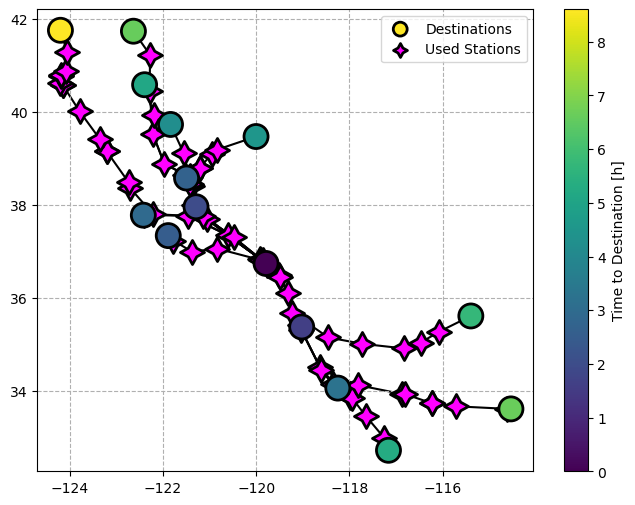

In [94]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if 'station' not in k]

src.figures.plot_route_tree(
    ax, graph,
    {k: v / 3600 for k, v in values.items()},
    # {},
    {k: v for k, v in paths.items() if 'station' not in k},
    destinations = destinations,
    show_unused_stations = False,
    **src.figures.default_route_tree_kwargs,
)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

In [106]:
utilized_stations = np.unique(np.concatenate([p[1: -1] for p in paths.values()]))

In [107]:
utilized_stations.shape

(356,)

In [113]:
radius = 5e3
field = 'distance'

_adj = graph._adj

reachable_stations = []

for source in utilized_stations:

    for target, edge in _adj[source].items():

        if (edge['type'] == 'station_station') and (edge[field] <= radius):

            reachable_stations.append(target)

reachable_stations = np.unique(reachable_stations)

In [114]:
reachable_stations.shape

(1168,)

In [119]:
destinations = [k for k, v in graph._node.items() if 'station' not in k]

sng_us = src.graph.subgraph(graph, list(utilized_stations) + destinations)
sng_rs = src.graph.subgraph(graph, list(reachable_stations) + destinations)

In [131]:
80 * 3.6e3 / 550 / 1.609, 100 * 3.6e3 / 550 / 1.609, 120 * 3.6e3 / 550 / 1.609

(325.4421153737499, 406.8026442171874, 488.1631730606249)

In [137]:
200 * 1.609 * 550 / 3.6e3, 300 * 1.609 * 550 / 3.6e3, 400 * 1.609 * 550 / 3.6e3

(49.16388888888889, 73.74583333333334, 98.32777777777778)

In [200]:
'''
Adding station objects
'''
deep_reload(src)

sng = tesla_sng_us

vehicle = src.routing.StochasticVehicle(
    capacity = 80 * 3.6e6,
    max_charge_start_soc = .5,
)

for source, node in sng._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], cases = 100,
        )

In [209]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    capacity = 80 * 3.6e6,
    # max_charge_start_soc = .5,
    cases = 100
)

t0 = time.time()

costs, values, paths = src.routing.bellman(
    sng, ['Fresno'], objective = vehicle, return_paths = True
)


print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 1.6872 seconds


In [210]:
print('Total Time:\n')
pprint({k: v['time'].mean() / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nDriving Time:\n')
pprint({k: v['driving_time'].mean() / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in r[2].items() if 'station' not in k})

Total Time:

{'Bakersfield': 7.168798296840154,
 'Chico': 4.230472506660021,
 'Crescent City': 9.367786996477445,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 7.397356754936844,
 'I-15 to Las Vegas (State Line)': 7.18243919180898,
 'I-80 to Reno (State Line)': 4.537769886363653,
 'Los Angeles': 3.2634172077922066,
 'Redding': 6.252996625924162,
 'Sacramento': 2.671335470085477,
 'San Diego': 7.378125657611442,
 'San Francisco': 2.9443037864912918,
 'San Jose': 7.975721530243021,
 'Stockton': 6.771320106204652,
 'Yreka': 7.737609622419549}

Driving Time:

{'Bakersfield': 6.587417894605396,
 'Chico': 4.230472506660021,
 'Crescent City': 8.617167526917523,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 6.691094183594185,
 'I-15 to Las Vegas (State Line)': 6.451887556887559,
 'I-80 to Reno (State Line)': 4.537769886363653,
 'Los Angeles': 3.2634172077922066,
 'Redding': 5.567442002442007,
 'Sacramento': 2.671335470085477,
 'San Diego': 6.580972225690979,
 'San Francisco': 2.944303786

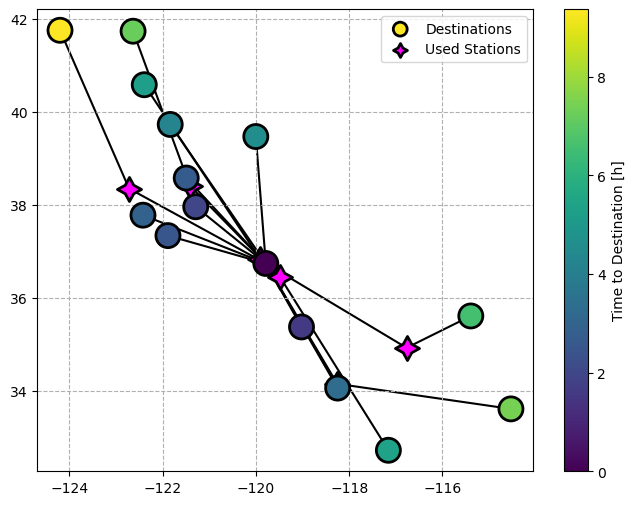

In [211]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if 'station' not in k]

src.figures.plot_route_tree(
    ax, graph,
    {k: v['time'].mean() / 3600 for k, v in values.items()},
    # {},
    {k: v for k, v in paths.items() if 'station' not in k},
    destinations = destinations,
    show_unused_stations = False,
    **src.figures.default_route_tree_kwargs,
)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

# plt.colorbar(cax = ax)